In [1]:
!pip install sentencepiece


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
import torch.nn as nn
from transformers import (
    BertTokenizer,
    DebertaV2Tokenizer,
    DebertaV2ForQuestionAnswering,
    BertModel
)
import pandas as pd

# Initialize both tokenizers
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
deberta_tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-base')

# Preprocess data for both BERT and DeBERTa
def preprocess_data(df):
    questions = df['question'].tolist()
    contexts = [" ".join([" ".join(context[1]) for context in item]) for item in df['context']]
    answers = df['answer'].tolist()
    
    # BERT Tokenization
    bert_query_encodings = bert_tokenizer(questions, padding=True, truncation=True, max_length=128, return_tensors="pt")
    bert_context_encodings = bert_tokenizer(contexts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    
    # DeBERTa Tokenization
    deberta_input_encodings = deberta_tokenizer(questions, contexts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    
    # Supporting Facts for Retrieval Labels using BERT Encodings
    supporting_facts = df['supporting_facts'].tolist()
    labels = []
    for i, facts in enumerate(supporting_facts):
        label = [0] * bert_context_encodings['input_ids'].size(1)
        for fact in facts:
            title, sent_idx = fact
            context = df['context'].iloc[i]
            for j, para in enumerate(context):
                if para[0] == title:
                    try:
                        sentence_tokens = bert_tokenizer.tokenize(para[1][sent_idx])
                        if len(sentence_tokens) == 0:
                            continue
                        start_idx = bert_tokenizer.convert_tokens_to_ids(sentence_tokens)[0]
                        input_ids_list = bert_context_encodings['input_ids'][i].tolist()
                        if start_idx in input_ids_list:
                            label[input_ids_list.index(start_idx)] = 1
                    except IndexError:
                        continue
        labels.append(label)
    
    # Return both BERT and DeBERTa processed data
    return {
        # BERT Encodings
        'bert_query_input_ids': bert_query_encodings['input_ids'],
        'bert_query_attention_mask': bert_query_encodings['attention_mask'],
        'bert_context_input_ids': bert_context_encodings['input_ids'],
        'bert_context_attention_mask': bert_context_encodings['attention_mask'],
        
        # DeBERTa Encodings
        'deberta_input_ids': deberta_input_encodings['input_ids'],
        'deberta_attention_mask': deberta_input_encodings['attention_mask'],
        
        # Labels
        'labels': torch.tensor(labels),
    }

# # Define GANModel with both BERT and DeBERTa components
# class RetrievalNetwork(nn.Module):
#     def __init__(self, bert_model='bert-base-uncased'):
#         super(RetrievalNetwork, self).__init__()
#         self.bert = BertModel.from_pretrained(bert_model)
#         self.classifier = nn.Linear(self.bert.config.hidden_size, 1)  # Binary classifier for relevance
# 
#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         pooled_output = outputs[1]  # [CLS] token representation
#         logits = self.classifier(pooled_output)
#         return logits

class AnswerGenerationNetwork(nn.Module):
    def __init__(self, deberta_model='microsoft/deberta-v3-base'):
        super(AnswerGenerationNetwork, self).__init__()
        self.deberta = DebertaV2ForQuestionAnswering.from_pretrained(deberta_model)
        
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.deberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            start_positions=labels[:, 0],
            end_positions=labels[:, 1]
        )
        return outputs.start_logits, outputs.end_logits, outputs.loss

class RetrievalNetwork(nn.Module):
    def __init__(self, bert_model='bert-base-uncased'):
        super(RetrievalNetwork, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 1)  # Binary classifier for each token

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # Use token-wise hidden states
        logits = self.classifier(sequence_output).squeeze(-1)  # Shape: [batch_size, sequence_length]
        return logits

class GANModel(nn.Module):
    def __init__(self):
        super(GANModel, self).__init__()
        self.retrieval_network = RetrievalNetwork()
        self.answer_generation_network = AnswerGenerationNetwork()

    def forward(self, preprocessed_data):
        # For BERT (Retrieval Network)
        retrieval_logits = self.retrieval_network(
            input_ids=preprocessed_data['bert_context_input_ids'],
            attention_mask=preprocessed_data['bert_context_attention_mask']
        )
        
        # Calculate retrieval loss
        retrieval_loss_fn = nn.BCEWithLogitsLoss()
        retrieval_loss = retrieval_loss_fn(retrieval_logits, preprocessed_data['labels'].float())
        
        # For DeBERTa (Answer Generation Network)
        start_logits, end_logits, generation_loss = self.answer_generation_network(
            input_ids=preprocessed_data['deberta_input_ids'],
            attention_mask=preprocessed_data['deberta_attention_mask'],
            labels=preprocessed_data['labels']
        )
        
        # Combine losses
        total_loss = retrieval_loss + generation_loss
        return total_loss, retrieval_logits, (start_logits, end_logits)


# Training loop with batch processing for GANModel
def train(model, optimizer, preprocessed_data, batch_size=4, epochs=3):
    print("Starting training...")
    model.train()

    # Split the data into batches for both BERT and DeBERTa tokenized inputs
    bert_context_batches = torch.split(preprocessed_data['bert_context_input_ids'], batch_size)
    bert_context_mask_batches = torch.split(preprocessed_data['bert_context_attention_mask'], batch_size)
    
    deberta_input_batches = torch.split(preprocessed_data['deberta_input_ids'], batch_size)
    deberta_attention_batches = torch.split(preprocessed_data['deberta_attention_mask'], batch_size)
    labels_batches = torch.split(preprocessed_data['labels'], batch_size)

    # Determine the number of batches
    num_batches = len(bert_context_batches)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_loss = 0.0

        for batch_idx in range(num_batches):
            optimizer.zero_grad()

            # Retrieve batch data for both BERT and DeBERTa
            bert_context_input_ids = bert_context_batches[batch_idx]
            bert_context_attention_mask = bert_context_mask_batches[batch_idx]
            deberta_input_ids = deberta_input_batches[batch_idx]
            deberta_attention_mask = deberta_attention_batches[batch_idx]
            labels = labels_batches[batch_idx]

            # Prepare preprocessed data dictionary for model forward pass
            batch_data = {
                'bert_context_input_ids': bert_context_input_ids,
                'bert_context_attention_mask': bert_context_attention_mask,
                'labels': labels,
                'deberta_input_ids': deberta_input_ids,
                'deberta_attention_mask': deberta_attention_mask
            }

            # Forward pass
            total_loss, retrieval_logits, generated_logits = model(batch_data)

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()

            # Accumulate the batch loss for the epoch
            epoch_loss += total_loss.item()
            print(f"Epoch [{epoch + 1}/{epochs}], Batch [{batch_idx + 1}/{num_batches}], Loss: {total_loss.item()}")

        # Average loss for the epoch
        avg_loss = epoch_loss / num_batches
        print(f"Epoch [{epoch + 1}/{epochs}] Average Loss: {avg_loss}")

    print("Training completed.")

# Load a small sample dataset and preprocess it
df = pd.read_json("hotpot_train_v1.1.json").sample(n=10000)
preprocessed_df = preprocess_data(df)

# Instantiate the model
model = GANModel()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Training loop
train(model, optimizer, preprocessed_df, epochs=3)

# save_directory = "./deberta_v3_base_model"
# 
# # Save tokenizer and model
# deberta_tokenizer.save_pretrained(save_directory)
# model.answer_generation_network.deberta.save_pretrained(save_directory)

# Load the tokenizer and model from the saved directory
# tokenizer = AutoTokenizer.from_pretrained(save_directory)
# model = AutoModelForQuestionAnswering.from_pretrained(save_directory)



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\PC\PycharmProjects\pythonProject1\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\PC\PycharmProjects\pythonProject1\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\PC\PycharmProjects\pythonProject1\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

Starting training...
Epoch 1/3
Epoch [1/3], Batch [1/2500], Loss: 7.185484409332275
Epoch [1/3], Batch [2/2500], Loss: 7.146399021148682
Epoch [1/3], Batch [3/2500], Loss: 7.035147190093994
Epoch [1/3], Batch [4/2500], Loss: 6.60031270980835
Epoch [1/3], Batch [5/2500], Loss: 6.502469062805176
Epoch [1/3], Batch [6/2500], Loss: 6.381110668182373
Epoch [1/3], Batch [7/2500], Loss: 6.338171482086182
Epoch [1/3], Batch [8/2500], Loss: 5.970200538635254
Epoch [1/3], Batch [9/2500], Loss: 5.862594127655029
Epoch [1/3], Batch [10/2500], Loss: 5.665922164916992
Epoch [1/3], Batch [11/2500], Loss: 5.621922016143799
Epoch [1/3], Batch [12/2500], Loss: 5.236872673034668
Epoch [1/3], Batch [13/2500], Loss: 5.279245376586914
Epoch [1/3], Batch [14/2500], Loss: 4.897632598876953
Epoch [1/3], Batch [15/2500], Loss: 4.903325080871582
Epoch [1/3], Batch [16/2500], Loss: 4.850433349609375
Epoch [1/3], Batch [17/2500], Loss: 4.6417436599731445
Epoch [1/3], Batch [18/2500], Loss: 4.565725326538086
Epoch 

In [4]:
# Define the directory where you want to save the model and tokenizer
save_directory = "./deberta_v3_base_model"

# Save the DeBERTa tokenizer and model
deberta_tokenizer.save_pretrained(save_directory)
model.answer_generation_network.deberta.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")


Model and tokenizer saved to ./deberta_v3_base_model


In [6]:
# Define the directory where you want to save the model and tokenizer
save_directory = "./deberta_v3_base_model1"

# Save the DeBERTa tokenizer and model
deberta_tokenizer.save_pretrained(save_directory)
model.answer_generation_network.deberta.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")


Model and tokenizer saved to ./deberta_v3_base_model2


In [7]:
# Define the directory where you want to save the model and tokenizer
save_directory = "./bert_model1"

# Save the DeBERTa tokenizer and model
bert_tokenizer.save_pretrained(save_directory)
model.retrieval_network.bert.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")


Model and tokenizer saved to ./bert_model1


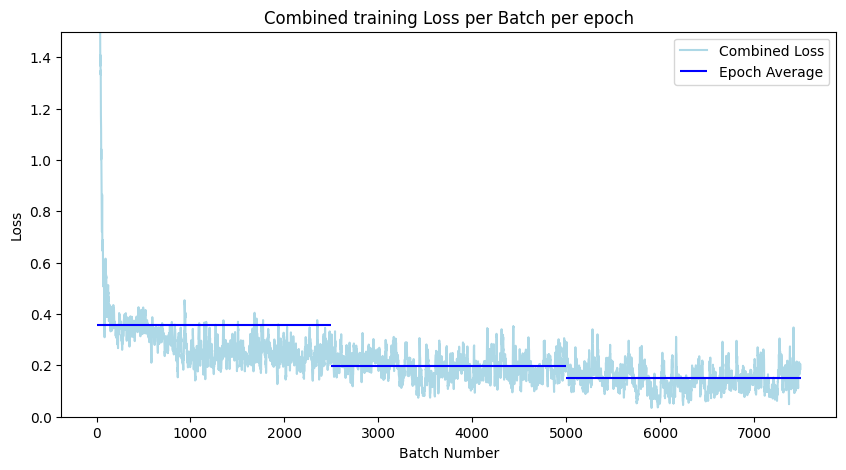

In [36]:
import re
import matplotlib.pyplot as plt
import numpy as np

# Read the log file
with open('loss.txt', 'r') as file:
    log = file.readlines()

# Extract batch losses
batch_losses = []
for line in log:
    match = re.search(r'Loss: ([\d\.]+)', line)
    if match:
        loss = float(match.group(1))
        batch_losses.append(loss)

# Apply a moving average for smoothing
window_size = 10  # Adjust window size for more or less smoothing
smoothed_losses = np.convolve(batch_losses, np.ones(window_size)/window_size, mode='valid')
avg_e1=0.35747247423231604
avg_e2=0.19631572096273303
avg_e3=0.14999720402713865
# Plotting the smoothed losses
plt.figure(figsize=(10, 5))
plt.plot(smoothed_losses, label='Combined Loss', color='lightblue')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.hlines(avg_e1,0,2500, color="blue", label="Epoch Average")
plt.hlines(avg_e2,2500, 5000, color="blue")
plt.hlines(avg_e3,5000,7500, color="blue")
# plt.vlines(x=2500, ymin=0, ymax=7)
# plt.vlines(x=5000, ymin=0, ymax=7)
plt.ylim(0,1.5)
plt.title('Combined training Loss per Batch per epoch')
plt.legend()
plt.show()
